In [22]:
from MiniTorch.nets.base import Net
from MiniTorch.nets.layers import Conv2D, Linear, MaxPool2d, PReLU, ReLU, SoftMax, Flatten
from MiniTorch.optimizers import SGD
from MiniTorch.losses import CCE
import matplotlib.pyplot as plt
import jax
import time
from MiniTorch.plotutils import show_conv_out
import jax.numpy as jnp

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist['data'], mnist['target']

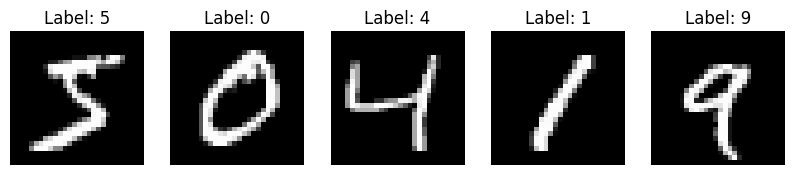

In [3]:
X = X.to_numpy()
y = y.to_numpy()
n_samples = X.shape[0]
image_size = (28, 28)
X_images = X.reshape(n_samples, 28,28)



def plot_sample_images(images, labels, num_samples=5):
    plt.figure(figsize=(10, 2))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title(f"Label: {labels[i]}")
        plt.axis('off')
    plt.show()
plot_sample_images(X_images, y, num_samples=5)

In [4]:
def get_training_data(X,Y,train_size):
    X_tra = X[:train_size]
    Y_tra = Y[:train_size]
    Y_tra = [[1 if j == int(i) else 0 for j in range(10)] for i in Y_tra]
    Y_tra = jnp.array(Y_tra)
    X_tra = jnp.reshape(jnp.array(X_tra),(train_size, 28,28))
    X_tra = jnp.expand_dims(X_tra,axis = 1)
    X_tra = X_tra.astype('float32')/255.
    return X_tra,Y_tra
X_tra, Y_tra = get_training_data(X,y,40000)

In [16]:
X_t = X[40000:40000+5000]
Y_t = y[40000:40000+5000]
Y_t = [[1 if j == int(i) else 0 for j in range(10)] for i in Y_t]
Y_t = jnp.array(Y_t)
X_t = jnp.reshape(jnp.array(X_t),(5000, 28,28))
X_t = jnp.expand_dims(X_t,axis = 1)
X_t = X_t.astype('float32')/255.

In [6]:
net = Net(
    [
        Conv2D(1,4,20, accumulate_grad_norm=True, accumulate_params=True, initialization='he'),
        MaxPool2d(2,2),
        Flatten(),
        Linear(2880, 50, accumulate_grad_norm=True,accumulate_parameters=True,initialization='he'),
        # PReLU(accumulate_grad_norm=True,accumulate_parameters=True),
        Linear(50, 10,accumulate_grad_norm=True,accumulate_parameters=True,initialization='he'),
        SoftMax()
    ],
    reproducibility_key=20
)

In [89]:
12 * 12 * 20

2880

In [ ]:
net.reinitialize_layers()

In [7]:
def yield_batches(X, Y, batch_size):
    """
    Yields batches of data and labels of the specified batch size.
    
    Args:
        X (numpy.ndarray): Input data array of shape (n_samples, ...) where ... is the feature shape.
        Y (numpy.ndarray): Label array of shape (n_samples, ...).
        batch_size (int): Size of each batch.
    
    Yields:
        tuple: (batch_X, batch_Y) where each is a slice of X and Y of size batch_size
               (or smaller for the last batch if n_samples % batch_size != 0).
    """
    n_samples = X.shape[0]
    
    # Ensure X and Y have compatible shapes
    assert n_samples == Y.shape[0], "Number of samples in X and Y must match"
    
    # Iterate over the dataset in chunks of batch_size
    for start_idx in range(0, n_samples, batch_size):
        end_idx = min(start_idx + batch_size, n_samples)
        yield X[start_idx:end_idx], Y[start_idx:end_idx]

In [8]:
epochs = 20
batch_size = 100
crit = CCE()
optimizer = SGD(0.0001,net)

In [9]:
for epoch in range(epochs):
    epoch_loss = 0
    for X_train, Y_train in yield_batches(X_tra,Y_tra,batch_size):
        pred = net.forward(X_train)
        loss = crit.loss(pred,Y_train)
        ini_grad = crit.backward(loss)
        optimizer.step(ini_grad)
        epoch_loss += loss
    print(f"Loss for {epoch}/{epochs} -> {epoch_loss/1000}")

Loss for 0/20 -> 0.46039438247680664
Loss for 1/20 -> 0.19520191848278046
Loss for 2/20 -> 0.15226656198501587
Loss for 3/20 -> 0.13358311355113983
Loss for 4/20 -> 0.1221729964017868
Loss for 5/20 -> 0.11400308459997177
Loss for 6/20 -> 0.107643723487854
Loss for 7/20 -> 0.10244113951921463
Loss for 8/20 -> 0.09801747649908066
Loss for 9/20 -> 0.09419562667608261
Loss for 10/20 -> 0.09083042293787003
Loss for 11/20 -> 0.08781963586807251
Loss for 12/20 -> 0.08508457988500595
Loss for 13/20 -> 0.0825645700097084
Loss for 14/20 -> 0.08023086190223694
Loss for 15/20 -> 0.07806393504142761
Loss for 16/20 -> 0.07603172957897186
Loss for 17/20 -> 0.0741085559129715
Loss for 18/20 -> 0.0722854733467102
Loss for 19/20 -> 0.07055189460515976


In [26]:
kernel_0 = net.layers[0].parameters['W'][0]

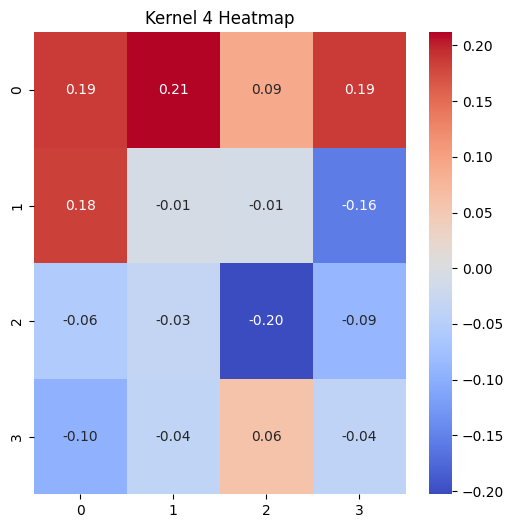

In [104]:
net.layers[0].plot_kernel(4)

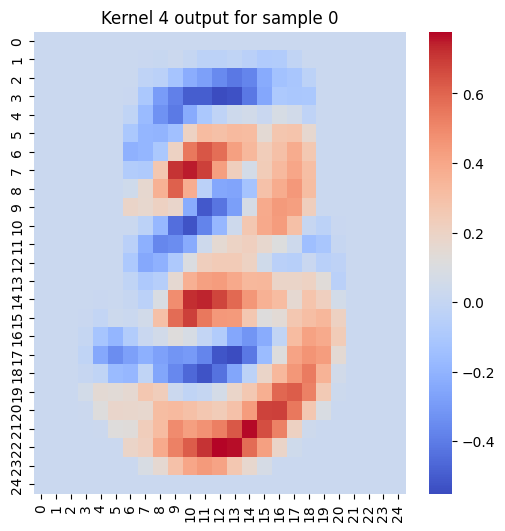

In [105]:
show_conv_out(net.layers[0],0,4)

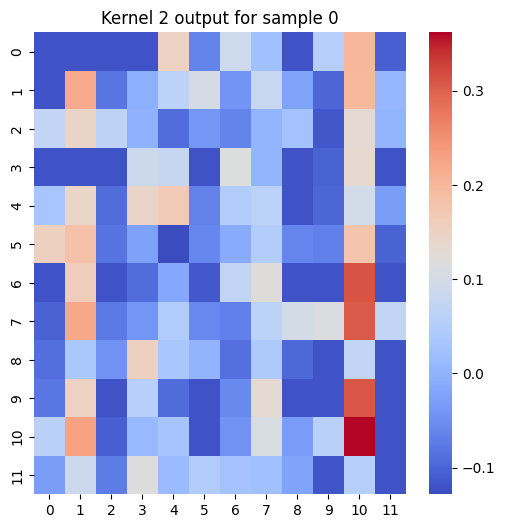

In [101]:
show_conv_out(net.layers[1],0,2)

In [17]:
res = net.forward(X_t)
loss = crit.loss(res,Y_t)
print(loss)

0.17137612


In [23]:
net.print_variance_info()

Linear 0
Weights Variance and Mean -> (Array(1.2042918, dtype=float32), Array(-0.01967998, dtype=float32))
Bias Variance and Mean -> (Array(0., dtype=float32), Array(0., dtype=float32))
Input Variance and Mean -> (Array(0.0919449, dtype=float32), Array(0.126595, dtype=float32))
Output Variance and Mean -> (Array(2.1836693, dtype=float32), Array(-0.04955678, dtype=float32))
Linear 3
Weights Variance and Mean -> (Array(1.0046912, dtype=float32), Array(-0.00155826, dtype=float32))
Bias Variance and Mean -> (Array(0., dtype=float32), Array(0., dtype=float32))
Input Variance and Mean -> (Array(2.3327687, dtype=float32), Array(0.5879611, dtype=float32))
Output Variance and Mean -> (Array(29116.602, dtype=float32), Array(-6.072758, dtype=float32))
Relu 4
Input Variance and Mean -> (Array(29116.602, dtype=float32), Array(-6.072758, dtype=float32))
Output Variance and Mean -> (Array(12477.077, dtype=float32), Array(46.308186, dtype=float32))
Linear 5
Weights Variance and Mean -> (Array(1.035388

In [9]:
net.print_variance_info()

Conv2D 0
Weights Variance and Mean -> (Array(0.01117783, dtype=float32), Array(-0.07683013, dtype=float32))
Bias Variance and Mean -> (Array(0.16920651, dtype=float32), Array(-0.45929724, dtype=float32))
Input Variance and Mean -> (Array(0.09613983, dtype=float32), Array(0.13251203, dtype=float32))
Output Variance and Mean -> (Array(0.46331933, dtype=float32), Array(-0.6628892, dtype=float32))
Linear 3
Weights Variance and Mean -> (Array(0.00148428, dtype=float32), Array(-0.00805826, dtype=float32))
Bias Variance and Mean -> (Array(0.00607282, dtype=float32), Array(0.00655353, dtype=float32))
Input Variance and Mean -> (Array(0.3458911, dtype=float32), Array(-0.5633386, dtype=float32))
Output Variance and Mean -> (Array(74770.83, dtype=float32), Array(98.24952, dtype=float32))
PReLU 4
Input Variance and Mean -> (Array(74770.83, dtype=float32), Array(98.24952, dtype=float32))
Output Variance and Mean -> (Array(302825.4, dtype=float32), Array(-97.10747, dtype=float32))
Linear 5
Weights V

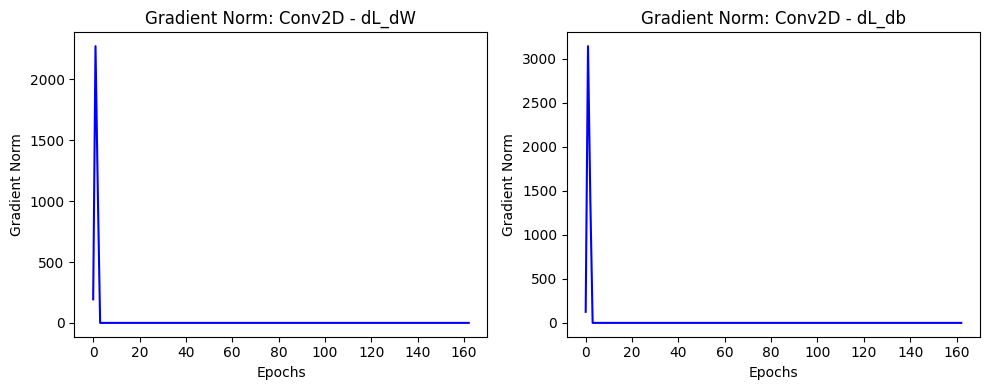

In [10]:
net.layers[0].plot_grad_norm()

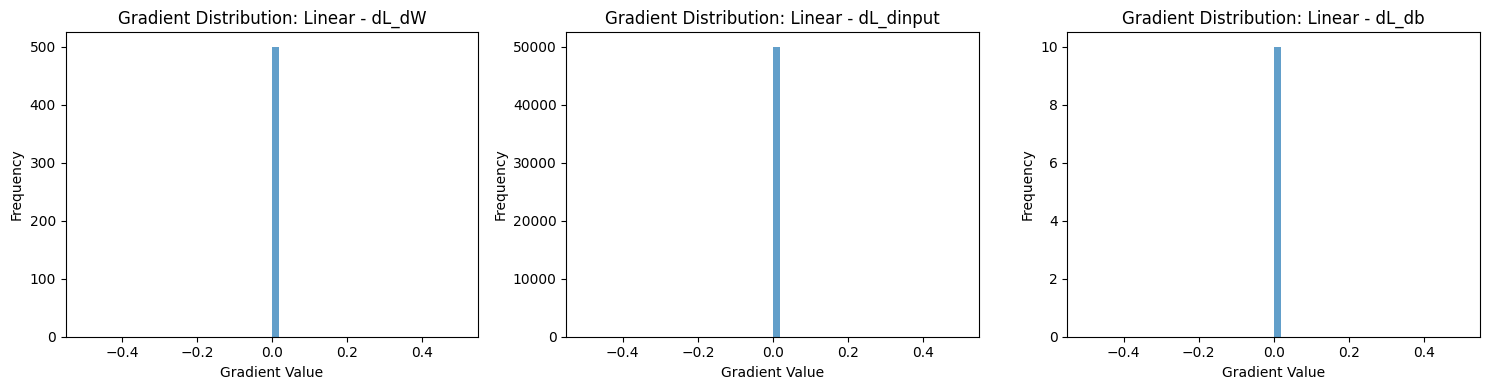

In [13]:
net.layers[5].plot_grad_dist()

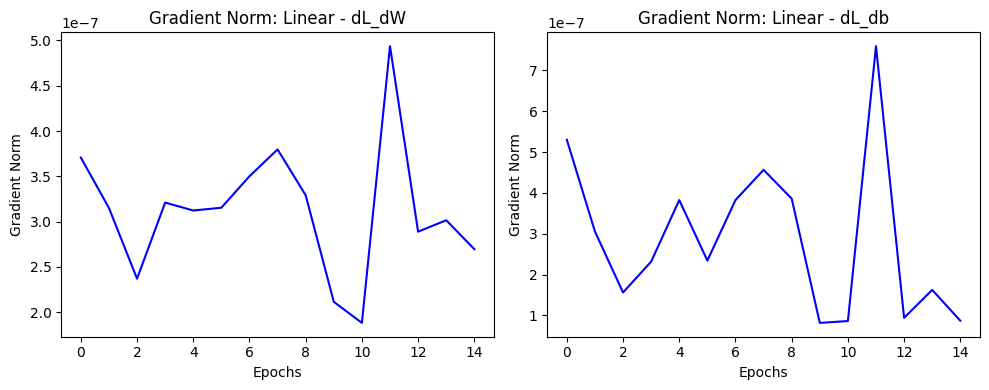

In [22]:
net.layers[-2].plot_grad_norm()

In [26]:
pred = net.forward(X_images)
loss = crit.loss(pred,Y)

In [27]:
ini_grad = crit.backward()

In [29]:
n_grad = net.layers[-1].backward(ini_grad)

In [31]:
n2_grad = net.layers[-2].backward(n_grad)

In [38]:
n3_grad = net.layers[-3].backward(n2_grad)

In [ ]:
n3_grad.

Array(0.0213101, dtype=float32)

In [47]:
float(net.layers[-2].grad_cache['dL_dW'].var())

0.30466559529304504

In [35]:
net.print_gradient_info()

In [36]:
net.layers[0].grad_cache

{}

In [ ]:
net.la

Array([[0.08994269, 0.06616123, 0.16419159, 0.10785104, 0.06971591,
        0.11118355, 0.09949122, 0.08941592, 0.11923791, 0.0828089 ]],      dtype=float32)

In [ ]:
net.layers[-1].backward(ini_grad)

SoftMax(requires_grad=False, _grad_norm={}, _accum_params={}, _accum_param_var_mean={}, grad_cache={'dL_dinput': Array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)}, accumulate_grad_norm=False, accumulate_parameters=False)

In [15]:
ini_grad = crit.backward()

In [17]:
ini_grad

Array([[  0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
        -10.351883,   0.      ,   0.      ,   0.      ,   0.      ]],      dtype=float32)

In [18]:
net.layers[-1].grad_cache

{'dL_dinput': Array([[2.6353767e-08, 2.5144498e-08, 2.5091239e-08, 2.4965079e-08,
         2.1306585e-08, 2.3031422e-08, 2.2559181e-08, 2.3867496e-08,
         2.1693191e-08, 2.4406114e-08]], dtype=float32)}

In [19]:
import jax.numpy as jnp
p = jnp.array([[0.0899, 0.0662, 0.1642, 0.1079, 0.0697, 0.1112, 0.0995, 0.0894, 0.1192, 0.0828]])
grad = jnp.array([[0, 0, 0, 0, 0, -10.351883, 0, 0, 0, 0]])
result = p * (grad - jnp.sum(p * grad, axis=1, keepdims=True))
print(result)

[[ 0.10348653  0.07620477  0.18901543  0.12420686  0.08023372 -1.0231237
   0.11453737  0.10291097  0.13721462  0.09531351]]


In [10]:
from MiniTorch.core.baseclasses import ComputationNode

In [ ]:
class Sigmoid(ComputationNode):

    def __init__(self):
        self.requires_grad = False

    def sigmoid(self,x):
        return 1/(1+jnp.exp(-x))
    def forward(self, x):
        self.input = x
        self.output = self.sigmoid(x)
        return self.output
    
    def backward(self, output_grad):
        self.grad_cache['dL_dinput'] = (self.output * (1 - self.output)) * output_grad
        return self.grad_cache['dL_dinput']
    
class Tanh(ComputationNode):

    def __init__(self):
        self.requires_grad = False

    def tanh(self,x):
        e_pos_x = jnp.exp(x)
        e_neg_x = jnp.exp(-x)
        numerator = e_pos_x - e_neg_x
        denominator = e_neg_x + e_pos_x
        tanh_res = numerator/denominator

    def forward(self, X):
        self.input = X
        self.output = self.tanh(X)
        return self.output
    
    def backward(self, output_grad):
        self.grad_cache['dL_dinput'] = (1 - jnp.power(self.output,2))*output_grad
        return self.grad_cache['dL_dinput']

class Dropout(ComputationNode):

    def __init__(self, p):
        super().__init__()
        self.p = p
        self.requires_grad = False
        self.mask = None
    def forward(self, x):
        if self.eval:
            return x
        self.input = x
        key = jax.random.PRNGKey(int(time.time()))
        mask = jax.random.bernoulli(key, self.p, x.shape).astype(jnp.float32)
        mask = mask / self.p
        self.mask = mask
        self.output = mask * x
        return self.output
    
    def backward(self, output_grad):
        self.grad_cache['dL_dinput'] = self.mask * output_grad
        return self.grad_cache['dL_dinput']
